<a href="https://colab.research.google.com/github/deltorobarba/science/blob/main/gravitation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Gravitational Waves**

In [ ]:
# gwpy and h5py for LIGOs HDF5 data
!pip install h5py gwpy ja gwosc PyWavelets matplotlib -q
from gwpy.timeseries import TimeSeries
from gwosc import datasets # gwosc provides access to all detected events
from gwpy.plot import Plot
import h5py
import matplotlib.pyplot as plt

In [2]:
# List all available events of gravitational waves
events = datasets.find_datasets(type="event")
print(f"Available events: {events[:10]}") # Limit output

Available events: ['151008-v1', '151012.2-v1', '151116-v1', '161202-v1', '161217-v1', '170208-v1', '170219-v1', '170405-v1', '170412-v1', '170423-v1']


In [3]:
# Select Signals by LIGO detectors (Hanford and Livingston), https://gwosc.org/eventapi/html/GWTC-1-marginal/
event = 'GW170608'  # from 8 June 2017. Collision of two black holes, https://arxiv.org/abs/1602.03839
#event = 'GW150914' # from 14 Sep 2015. First observation of a binary black hole merger
#event = 'GW170814' # from 14 Aug 2017 probe for the first time the polarization of gravitational waves

# Get/Verify GPS time for event (from gwosc import datasets)
time = datasets.event_gps(event)
print(f"GPS Time for {event}: {time}")

GPS Time for GW170608: 1180922494.5


In [4]:
#### Load and Inspect data ####
# LIGO and Virgo are designed for frequencies between 1 and 100 Hertz
# Fetch LIGO data for gravitational wave event from gwosc import datasets
def load_ligo_data(event=event, detector='H1', duration=32):
    # Start time of the event (GPS timestamp)
    event_time = time  # event time in GPS seconds

    # Fetch strain data around event
    start_time = event_time - duration // 2
    end_time = event_time + duration // 2

    # Fetch strain data for a specific detector (H1 or L1)
    data = TimeSeries.fetch_open_data(detector, start_time, end_time, cache=True)
    return data

# Load strain data for Hanford (H1) and Livingston (L1) detectors
h1_data = load_ligo_data(event=event, detector='H1')
l1_data = load_ligo_data(event=event, detector='L1')

# h1_data.write("l1_data.hdf5", format="hdf5")
# print("Data saved as H1_GW170814.hdf5")

#### Alternative data loading methods ####

# Load data manually from github or science website
# !wget https://www.gw-openscience.org/s/events/GW150914/H-H1_LOSC_4_V2-1126259446-32.hdf5

# Load data from gwpy.timeseries
# h1_data = TimeSeries.fetch_open_data('H1', time - 16, time + 16, cache=True)
# l1_data = TimeSeries.fetch_open_data('L1', time - 16, time + 16, cache=True)

print("Hanford Data (H1):\n" + 40*"-")
print(f"Start Time:    {h1_data.times.value[0]} GPS seconds")
print(f"End Time:      {h1_data.times.value[-1]} GPS seconds")
print(f"Sampling Rate: {h1_data.sample_rate} Hz")
print(f"Duration:      {h1_data.duration.value} seconds")
print(f"Records:       {len(h1_data)}")
print(h1_data)

print("\nLivingston Data (L1):\n" + 40*"-")
print(f"Start Time:    {l1_data.times.value[0]} GPS seconds")
print(f"End Time:      {l1_data.times.value[-1]} GPS seconds")
print(f"Sampling Rate: {l1_data.sample_rate} Hz")
print(f"Duration:      {l1_data.duration.value} seconds")
print(f"Records:       {len(l1_data)}")
print(l1_data)

Hanford Data (H1):
----------------------------------------
Start Time:    1180922478.5 GPS seconds
End Time:      1180922510.4997559 GPS seconds
Sampling Rate: 4096.0 Hz Hz
Duration:      32.0 seconds
Records:       131072
TimeSeries([ 4.19154946e-20, -6.28038125e-20, -4.18279795e-20,
            ...,  5.61727307e-19,  5.55467777e-19,
             6.67973405e-19]
           unit: dimensionless,
           t0: 1180922478.5 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)

Livingston Data (L1):
----------------------------------------
Start Time:    1180922478.5 GPS seconds
End Time:      1180922510.4997559 GPS seconds
Sampling Rate: 4096.0 Hz Hz
Duration:      32.0 seconds
Records:       131072
TimeSeries([4.59339523e-19, 4.72353825e-19, 4.69751992e-19, ...,
            1.98060571e-19, 1.89789463e-19, 1.91393863e-19]
           unit: dimensionless,
           t0: 1180922478.5 s,
           dt: 0.000244140625 s,
           name: Strain,
           c

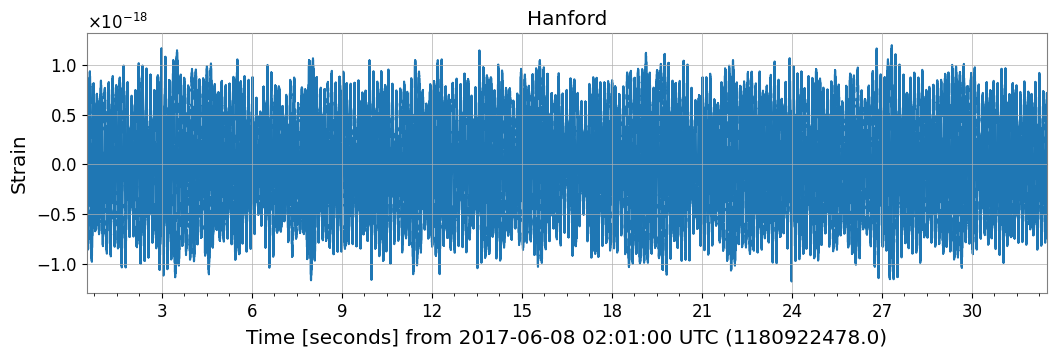

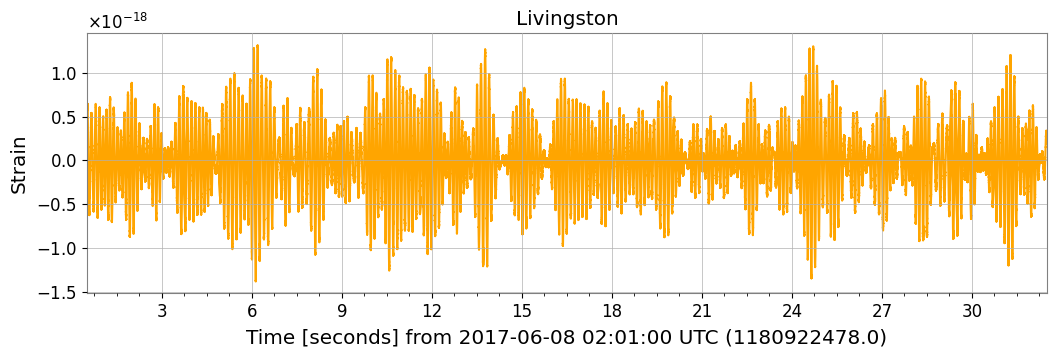

In [6]:
# Plot raw strain data for Hanford (H1) and Livingston (L1)
plot_h1a = h1_data.plot(title='Hanford')
plt.ylabel("Strain")
plt.show()

plot_l1a = l1_data.plot(title='Livingston', color='orange')
plt.ylabel("Strain")
plt.show()

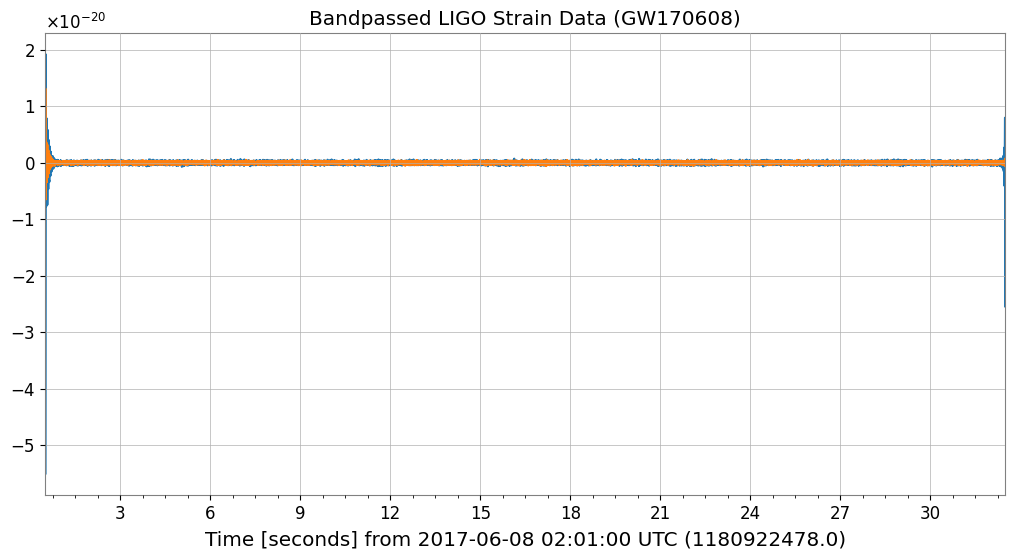

In [7]:
# PREPROCESSING: Bandpass Filter and Whitening

# BANDPASS FILTER between 30 Hz and 300 Hz (Gravitational wave signals)
h1_data_bp = h1_data.bandpass(30, 400)
l1_data_bp = l1_data.bandpass(30, 400)
plot = Plot(h1_data_bp, l1_data_bp, title=f"Bandpassed LIGO Strain Data ({event})")
#plot.show()

# WHITENING to strain data. Makes noise spectrum flat across frequencies. Enhances gravitational wave signal
# (Lower frequencies may be dominated by seismic noise, higher frequencies can be influenced by quantum shot noise)
# Whitening divides signal by amplitude spectral density of noise. Results in spectrum where each frequency component has approx. same noise level
h1_data_white = h1_data_bp.whiten()
l1_data_white = l1_data_bp.whiten()
#plot = Plot(h1_data_white, l1_data_white, title=f"Whitened LIGO Strain Data ({event})")

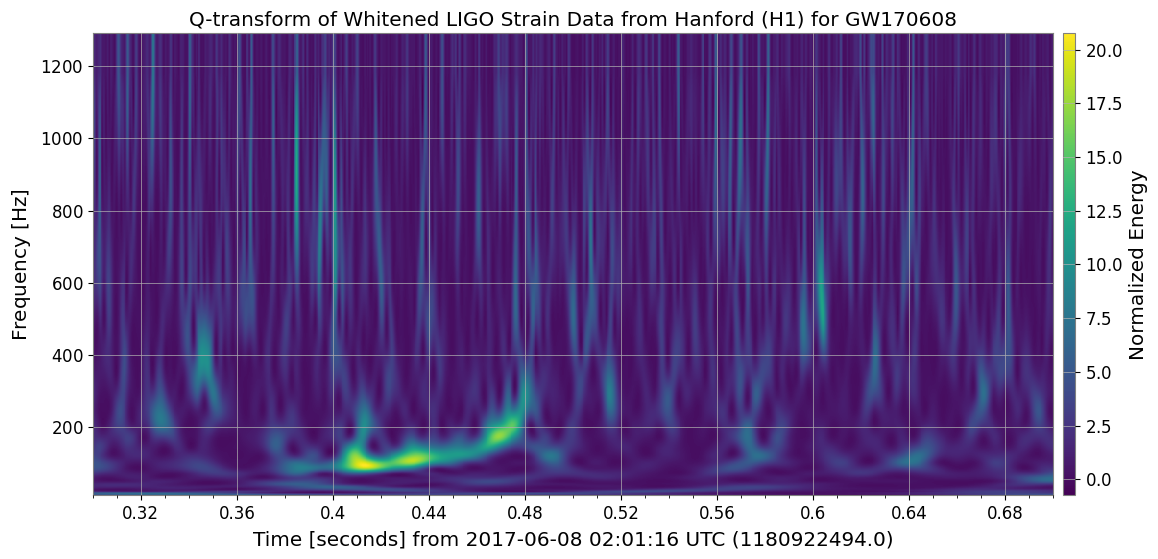

In [8]:
# Q-transform plot of whitened data (time-frequency representation) for short duration signals
q_transform_h1 = h1_data_white.q_transform(outseg=(time-0.2, time + 0.2))
plot = q_transform_h1.plot()
plot.colorbar(label="Normalized Energy")
plt.gca().set_title(f"Q-transform of Whitened LIGO Strain Data from Hanford (H1) for {event}")
#plt.ylim(0, 700) # Limit up to 700 Hz max
plt.show()

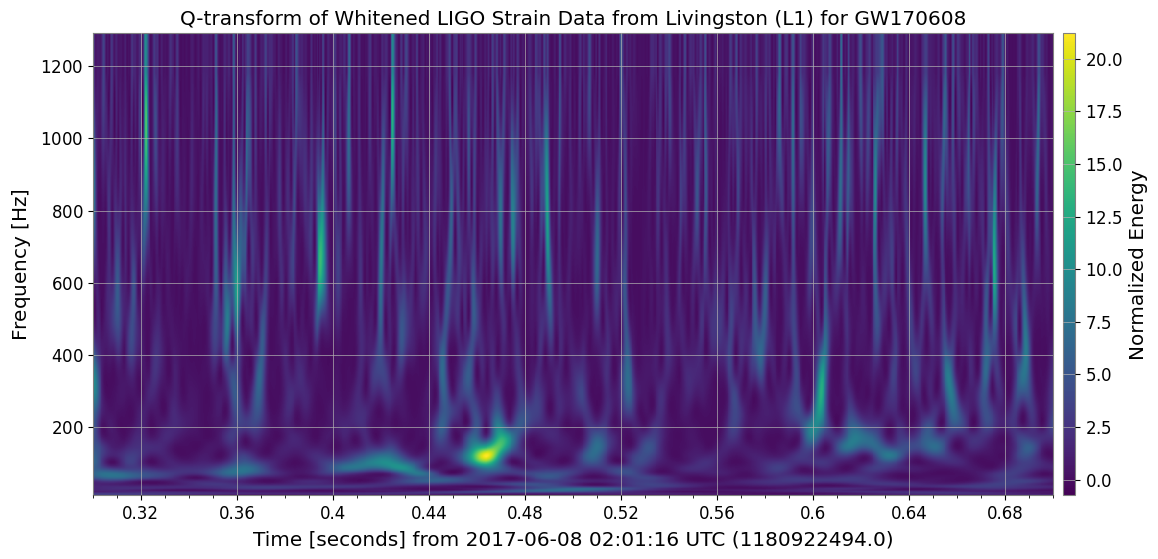

In [9]:
# Q-transform plot of whitened data (time-frequency representation) for short duration signals
q_transform_l1 = l1_data_white.q_transform(outseg=(time-0.2, time + 0.2))
plot = q_transform_l1.plot()
plot.colorbar(label="Normalized Energy")
plt.gca().set_title(f"Q-transform of Whitened LIGO Strain Data from Livingston (L1) for {event}")
#plt.ylim(0, 700) # Limit up to 700 Hz max
plt.show()